In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read train data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sub = pd.read_csv("data/sample_submission.csv")

print(train.shape, test.shape, sub.shape)

(9366, 18) (4801, 17) (4801, 2)


In [3]:
train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,1.098097e+08,20040720,NaN,20040812,B,NaN,NaN,0.02496
1,PF00001003,DSK00001002,OFF00001001,A,20040709,176671000.0,N,0.02074,GBP,5.269617,1.760084e+08,20040723,NaN,20040812,C,NaN,NaN,0.05496
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,5.637953e+07,20040723,NaN,20040817,A,NaN,NaN,0.02496
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,1.645088e+08,20040723,NaN,20040713,A,NaN,NaN,0.02496
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,1.405402e+08,20040723,NaN,20040713,B,NaN,NaN,0.02496


In [4]:
def categorical_stats(col):
    unq_train = train[col].unique()
    unq_test = test[col].unique()
    common = set(unq_train).intersection(set(unq_test))
    print("Unique values in train for {} are {} ".format(col, len(unq_train)))
    print("Unique values in test for {} are {} ".format(col, len(unq_test)))
    print("Values common in train and test for {} are {} ".format(col, len(common)))
    print("Most frequent values are ", train[col].fillna('No value').astype(str).value_counts()[:2])
    

In [5]:
train.columns

Index(['portfolio_id', 'desk_id', 'office_id', 'pf_category', 'start_date',
       'sold', 'country_code', 'euribor_rate', 'currency', 'libor_rate',
       'bought', 'creation_date', 'indicator_code', 'sell_date', 'type',
       'hedge_value', 'status', 'return'],
      dtype='object')

In [6]:
cat_cols = ["desk_id", 'office_id', 'pf_category', 'country_code', 'euribor_rate', 'currency', 'libor_rate',
       'indicator_code', 'type',
       'hedge_value', 'status']

In [7]:
for col in cat_cols:
    categorical_stats(col)
    print()
    print()

Unique values in train for desk_id are 3993 
Unique values in test for desk_id are 2198 
Values common in train and test for desk_id are 889 
Most frequent values are  No value       3665
DSK00005869      10
Name: desk_id, dtype: int64


Unique values in train for office_id are 2 
Unique values in test for office_id are 2 
Values common in train and test for office_id are 2 
Most frequent values are  OFF00001002    6458
OFF00001001    2908
Name: office_id, dtype: int64


Unique values in train for pf_category are 5 
Unique values in test for pf_category are 4 
Values common in train and test for pf_category are 4 
Most frequent values are  C    5260
A    2424
Name: pf_category, dtype: int64


Unique values in train for country_code are 5 
Unique values in test for country_code are 5 
Values common in train and test for country_code are 5 
Most frequent values are  M    5307
T    2955
Name: country_code, dtype: int64


Unique values in train for euribor_rate are 149 
Unique values in te

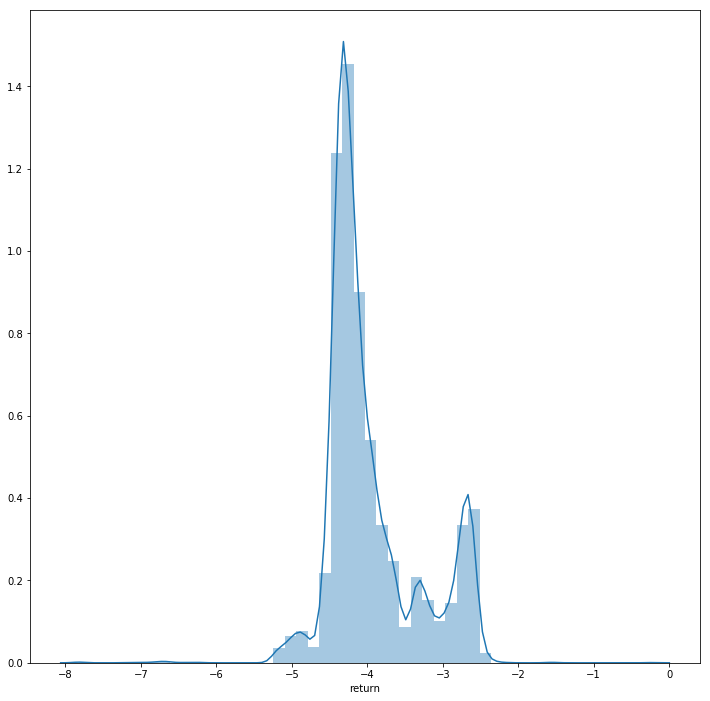

In [8]:
#Lets plot target variable
plt.figure(figsize=(12,12))
sns.distplot(np.log(train['return'] + 0.01))
plt.show()

In [9]:
train['return'].describe()

count    9366.000000
mean        0.014100
std         0.020549
min        -0.009600
25%         0.003000
50%         0.005400
75%         0.014520
max         0.778441
Name: return, dtype: float64

In [10]:
def plot_continous(col):
    med = train[col].median()
    pct_1 = train[col].quantile(0.01)
    pct_99 = train[col].quantile(0.99)
    sns.distplot(train[col].fillna(med).clip(pct_1, pct_99))
    sns.distplot(test[col].fillna(med).clip(pct_1, pct_99))
    plt.title(col)
    plt.show()
    
    sns.jointplot(train[col].fillna(med).clip(pct_1, pct_99), np.log(train['return'] + 0.01))
    plt.title(col)
    plt.show()

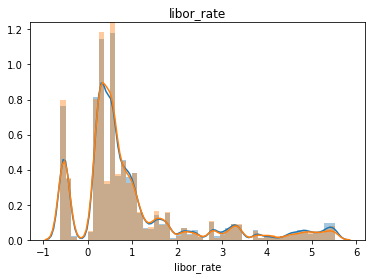

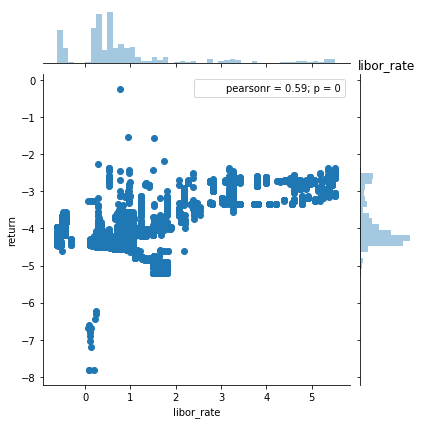

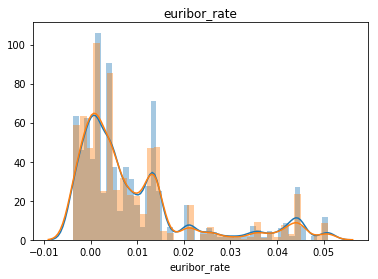

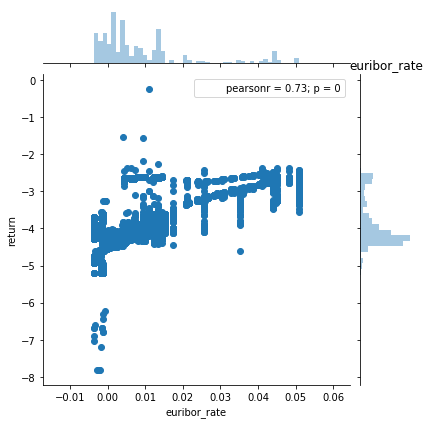

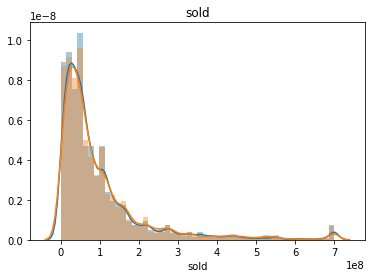

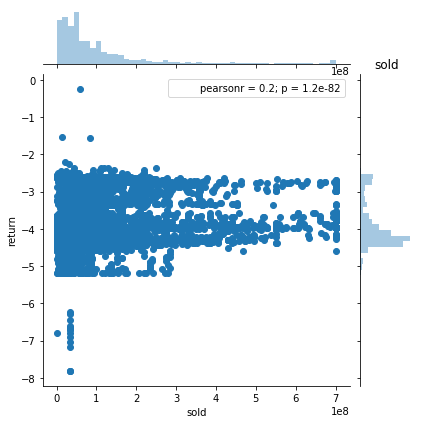

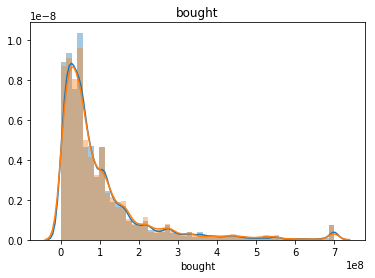

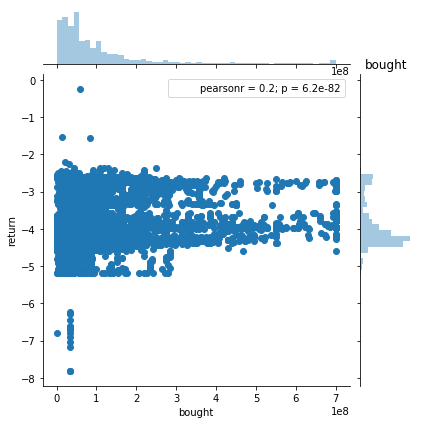

In [11]:
for col in ["libor_rate", "euribor_rate", "sold", "bought"]:
    plot_continous(col)

In [12]:
pd.to_datetime("20040720")

Timestamp('2004-07-20 00:00:00')

In [13]:
#More features can be derived from date columns
def parse_dates(col):
    train[col] = pd.to_datetime(train[col].astype(str), format="%Y%m%d")
    test[col] = pd.to_datetime(test[col].astype(str))
    
for col in ["start_date", "creation_date", "sell_date"]:
    parse_dates(col)

In [14]:
#More features based on dates
def date_features(df):
    df["pf_duration"] = np.abs((df["sell_date"] - df["start_date"]).dt.days)
    df["pf_duration_weeks"] = df["pf_duration"]// 7 + 1
    df["pf_duration_months"] = df["pf_duration"]// 30 + 1
    df["pf_delay"] = (df["start_date"] - df["creation_date"]).dt.days
    df["bought_year"] = df.start_date.dt.year
    df["sell_year"] = df.sell_date.dt.year
    df['bought_qtr'] = df.creation_date.dt.quarter
    df['bought_month'] = df.creation_date.dt.month
    df['bought_day'] = df.creation_date.dt.dayofyear
    df['bought_weekofyear'] = df.creation_date.dt.weekofyear
    df['bought_dayofweek'] = df.creation_date.dt.dayofweek
    
for df in train, test:
    date_features(df)

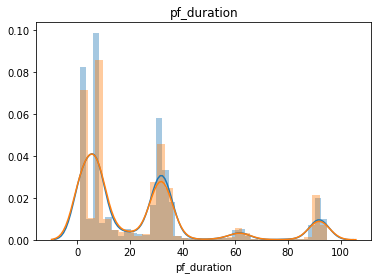

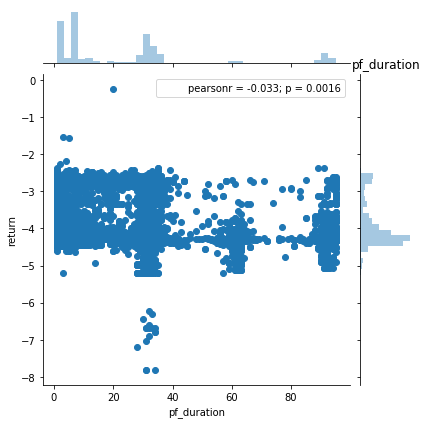

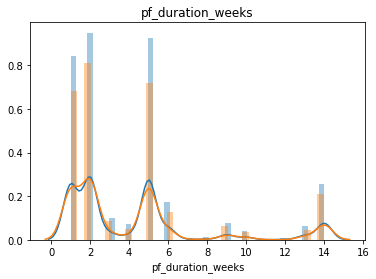

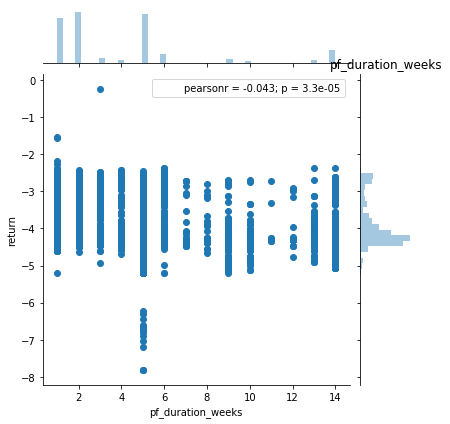

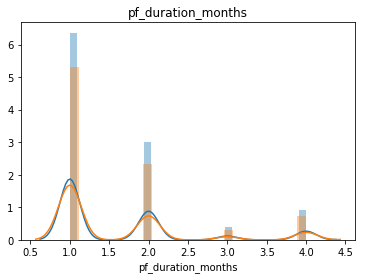

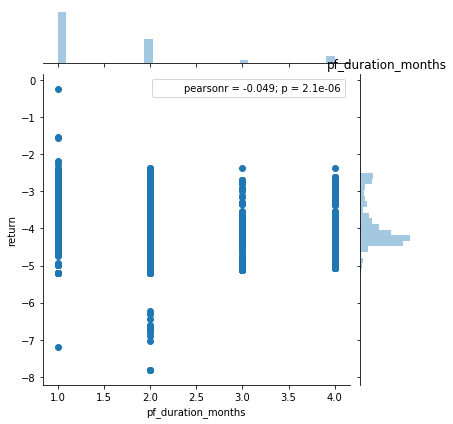

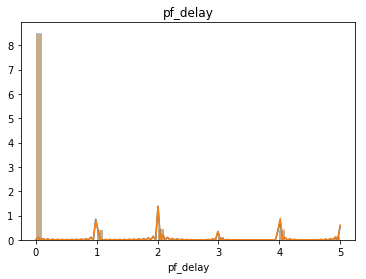

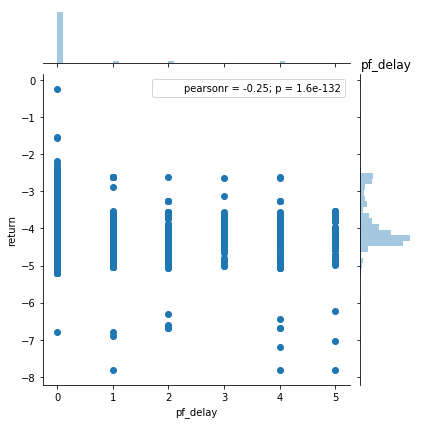

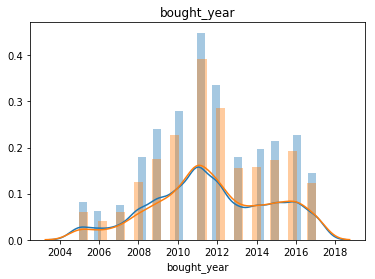

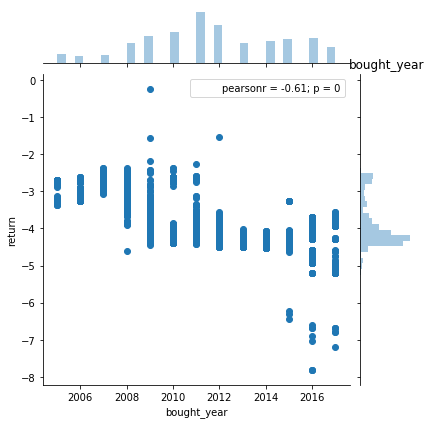

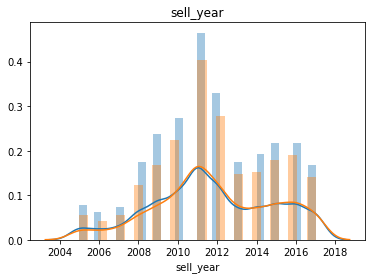

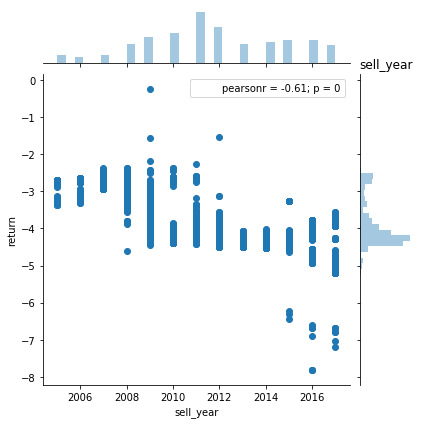

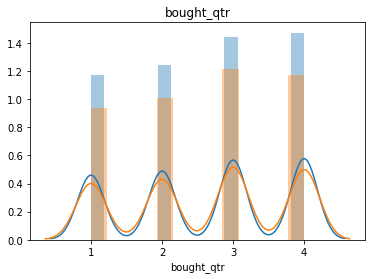

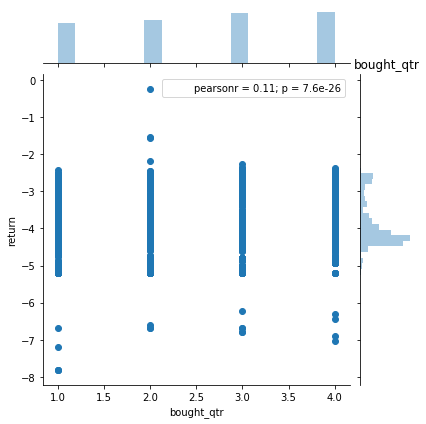

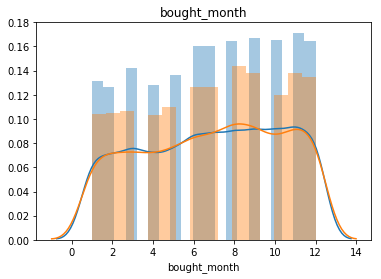

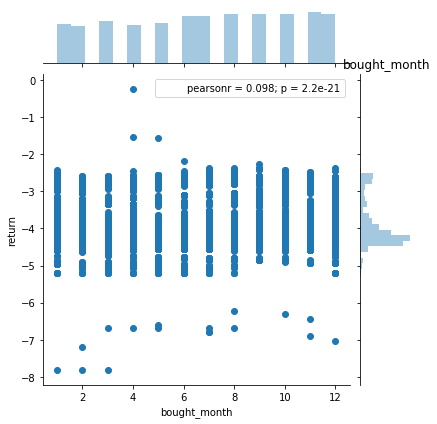

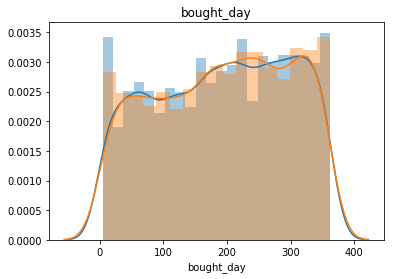

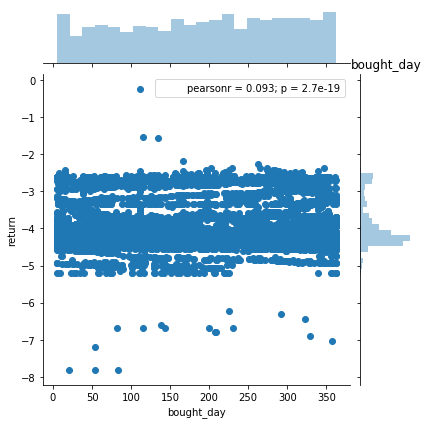

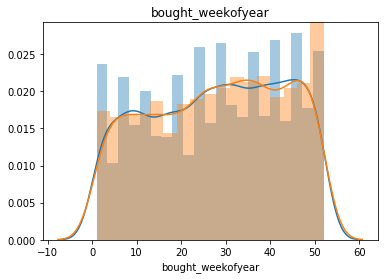

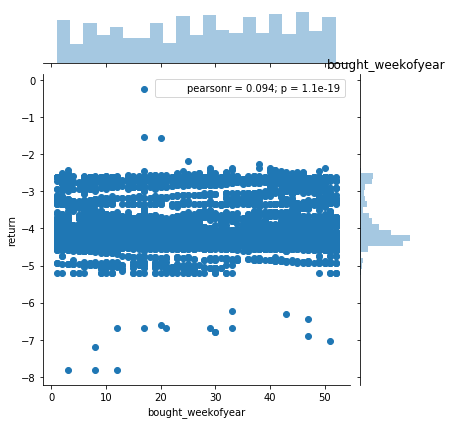

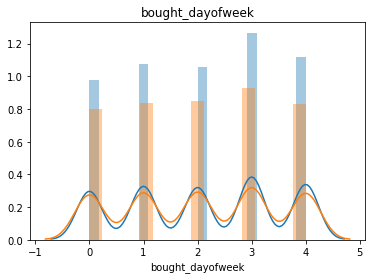

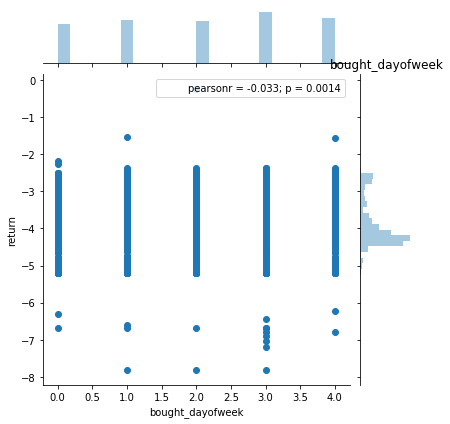

In [15]:
for col in ["pf_duration", "pf_duration_weeks", "pf_duration_months", "pf_delay", "bought_year", "sell_year", "bought_qtr",
           "bought_month", "bought_day", "bought_weekofyear", "bought_dayofweek"]:
    plot_continous(col)

In [16]:
print(train.isnull().sum())
print(test.isnull().sum())

portfolio_id             0
desk_id               3665
office_id                0
pf_category              0
start_date               0
sold                     2
country_code             0
euribor_rate             0
currency                 0
libor_rate             474
bought                   2
creation_date            0
indicator_code        5699
sell_date                0
type                     0
hedge_value           5701
status                3084
return                   0
pf_duration              0
pf_duration_weeks        0
pf_duration_months       0
pf_delay                 0
bought_year              0
sell_year                0
bought_qtr               0
bought_month             0
bought_day               0
bought_weekofyear        0
bought_dayofweek         0
dtype: int64
portfolio_id             0
desk_id               1948
office_id                0
pf_category              0
start_date               0
sold                     0
country_code             0
euribor_rate   

In [17]:
#Alright, enough of exploration. Let's dive into modelling
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
cat_cols = cat_cols = ["desk_id", 'office_id', 'pf_category', 'country_code', 'currency',
       'indicator_code', 'type',
       'hedge_value', 'status']

def convert_categoricals(cols):
    lb_enc = defaultdict(LabelEncoder)
    for col in cols:
        print("Converting {} to label encoding".format(col))
        lb_enc[col].fit(pd.concat([train[col], test[col]]).fillna(-1).astype(str).reshape(-1,1))
        for df in train, test:
            df[col + '_enc'] = lb_enc[col].transform(df[col].fillna(-1).astype(str).reshape(-1,1))
            
convert_categoricals(cat_cols)

Converting desk_id to label encoding
Converting office_id to label encoding
Converting pf_category to label encoding
Converting country_code to label encoding
Converting currency to label encoding
Converting indicator_code to label encoding
Converting type to label encoding
Converting hedge_value to label encoding
Converting status to label encoding


/home/test/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
/home/test/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/test/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/home/test/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,...,bought_dayofweek,desk_id_enc,office_id_enc,pf_category_enc,country_code_enc,currency_enc,indicator_code_enc,type_enc,hedge_value_enc,status_enc
0,PF00001002,DSK00001001,OFF00001002,B,2004-07-20,110000000.0,T,0.02074,USD,2.332216,...,1,1,1,1,2,4,0,1,0,0
1,PF00001003,DSK00001002,OFF00001001,A,2004-07-09,176671000.0,N,0.02074,GBP,5.269617,...,4,2,0,0,1,2,0,2,0,0
2,PF00001005,DSK00001004,OFF00001001,A,2004-07-23,56474000.0,T,0.02074,USD,2.332216,...,4,4,0,0,2,4,0,0,0,0
3,PF00001006,DSK00001005,OFF00001001,A,2004-06-09,164813000.0,T,0.02074,USD,2.332216,...,4,5,0,0,2,4,0,0,0,0
4,PF00001007,DSK00001005,OFF00001002,B,2004-06-09,140800000.0,T,0.02074,USD,2.332216,...,4,5,1,1,2,4,0,1,0,0


In [19]:
#Now drop columns with no bought or sold info from test
train.dropna(subset=['bought', 'sold'], inplace=True)

In [20]:
#Finally for libor rate, just fill -1
train['libor_rate'] = train['libor_rate'].fillna(-1)
test['libor_rate'] = test['libor_rate'].fillna(-1)

In [21]:
train.columns

Index(['portfolio_id', 'desk_id', 'office_id', 'pf_category', 'start_date',
       'sold', 'country_code', 'euribor_rate', 'currency', 'libor_rate',
       'bought', 'creation_date', 'indicator_code', 'sell_date', 'type',
       'hedge_value', 'status', 'return', 'pf_duration', 'pf_duration_weeks',
       'pf_duration_months', 'pf_delay', 'bought_year', 'sell_year',
       'bought_qtr', 'bought_month', 'bought_day', 'bought_weekofyear',
       'bought_dayofweek', 'desk_id_enc', 'office_id_enc', 'pf_category_enc',
       'country_code_enc', 'currency_enc', 'indicator_code_enc', 'type_enc',
       'hedge_value_enc', 'status_enc'],
      dtype='object')

In [22]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, ShuffleSplit
from sklearn import metrics
feats = ['pf_duration', 'bought_year', 'sell_year', 'bought_qtr',
         'desk_id_enc', 'office_id_enc', 'pf_category_enc', 'country_code_enc', 
         'currency_enc', 'indicator_code_enc', 'type_enc', 'hedge_value_enc', 'status_enc',
        'euribor_rate', 'libor_rate', 'bought', 'sold', 'pf_duration_months', 'pf_duration_weeks']

X = train[feats]
X_test = test[feats]
y = train['return']

cvlist = list(ShuffleSplit(50, random_state=123).split(X, y))

print(X.shape, X_test.shape)

(9364, 19) (4801, 19)


In [23]:
r2score = metrics.make_scorer(metrics.r2_score, greater_is_better=True)

In [24]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge

etr = ExtraTreesRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=50)
ridge = Ridge()
scores = cross_val_score(etr, X, y, scoring=r2score, cv=cvlist, verbose=10)
print(scores)
print(np.mean(scores), np.std(scores))

[CV]  ................................................................
[CV] ....................... , score=0.9608953653223368, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ...................... , score=0.33448902898874844, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] ....................... , score=0.9587566506192305, total=   0.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV] ........................ , score=0.971870938331569, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s


[CV] ....................... , score=0.9462252939945334, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s


[CV] ....................... , score=0.9701428039078922, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.2s remaining:    0.0s


[CV] ....................... , score=0.9740882591637674, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.7s remaining:    0.0s


[CV] ....................... , score=0.9696175835204511, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.2s remaining:    0.0s


[CV] ....................... , score=0.3388455726502575, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.8s remaining:    0.0s


[CV] ....................... , score=0.8464439612121732, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9618884580725628, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9382821121695274, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9601332040087496, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9784444923886232, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9481085076549719, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.8333170237028656, total=   0.6s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   26.8s finished


In [25]:
import lightgbm as lgb
lgb1 = lgb.LGBMRegressor(boosting_type='dart', 
                         learning_rate=0.05,
                         n_estimators=800, 
                         num_leaves=15, 
                         subsample=0.7, 
                         colsample_bytree=0.7,
                         min_child_samples=200)
scores = cross_val_score(etr, X, y, scoring=r2score, cv=cvlist, verbose=10)
print(scores)
print(np.mean(scores), np.std(scores))

[CV]  ................................................................
[CV] ....................... , score=0.9614239694727607, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ........................ , score=0.333935351642928, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ....................... , score=0.9582693603823147, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.9721515448084271, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s


[CV] ....................... , score=0.9459770761257513, total=   0.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s


[CV] ....................... , score=0.9689190523990691, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.9743014608725331, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.8s remaining:    0.0s


[CV] ....................... , score=0.9691001150147517, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.3s remaining:    0.0s


[CV] ....................... , score=0.3403981131762318, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.9s remaining:    0.0s


[CV] ....................... , score=0.8469748151311901, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9612600664154828, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9374201762160835, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9612223192048001, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9766124250842778, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9458026731099651, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.8342459424051772, total=   0.5s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.0s finished


In [26]:
from BinaryEncoder import BinaryEncoder
from FeatureSelector import FeatureSelector
from TargetEncoder import TargetEncoder
from sklearn.pipeline import Pipeline, make_pipeline, make_union
import category_encoders as en
from sklearn.preprocessing import QuantileTransformer

In [27]:
cont_cols = ['pf_duration','euribor_rate', 'libor_rate', 'bought', 'sold']
cat_cols = ['bought_year', 'sell_year', 'bought_qtr',
         'desk_id_enc', 'office_id_enc', 'pf_category_enc', 'country_code_enc', 
         'currency_enc', 'indicator_code_enc', 'type_enc', 'hedge_value_enc', 'status_enc']

bin_enc = BinaryEncoder(cols=cat_cols)
pipe1 = make_pipeline(bin_enc, etr)
scores = cross_val_score(pipe1, X, y, scoring=r2score, cv=cvlist, verbose=10)
print(scores)
print(np.mean(scores), np.std(scores))

[CV]  ................................................................
(8427, 46)
(937, 46)
[CV] ....................... , score=0.9604132793371728, total=   1.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


(8427, 46)
(937, 46)
[CV] ....................... , score=0.3358846173276051, total=   1.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


(8427, 46)
(937, 46)
[CV] ....................... , score=0.9587370296628748, total=   1.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s


(8427, 46)
(937, 46)
[CV] ....................... , score=0.9685340844198618, total=   1.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.2s remaining:    0.0s


(8427, 46)
(937, 46)
[CV] ....................... , score=0.9458041315685214, total=   1.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.3s remaining:    0.0s


(8427, 46)
(937, 46)
[CV] ....................... , score=0.9653836368552098, total=   1.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.5s remaining:    0.0s


(8427, 46)
(937, 46)
[CV] ....................... , score=0.9727575965870829, total=   1.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.5s remaining:    0.0s


(8427, 46)
(937, 46)
[CV] ........................ , score=0.963975204926686, total=   1.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.8s remaining:    0.0s


(8427, 46)
(937, 46)
[CV] ...................... , score=0.34130929142889743, total=   1.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.0s remaining:    0.0s


(8427, 46)
(937, 46)
[CV] ....................... , score=0.8421247572711859, total=   1.2s
[CV]  ................................................................
(8427, 46)
(937, 46)
[CV] ....................... , score=0.9594489548600307, total=   1.3s
[CV]  ................................................................
(8427, 46)
(937, 46)
[CV] ....................... , score=0.9295408512152256, total=   1.2s
[CV]  ................................................................
(8427, 46)
(937, 46)
[CV] ....................... , score=0.9567793382218694, total=   1.4s
[CV]  ................................................................
(8427, 46)
(937, 46)
[CV] ....................... , score=0.9718100144387453, total=   1.3s
[CV]  ................................................................
(8427, 46)
(937, 46)
[CV] ....................... , score=0.9479405365658312, total=   1.4s
[CV]  ................................................................
(8427, 46)
(937, 46)
[

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   58.7s finished


In [28]:
onehot_enc = en.OneHotEncoder(cols=cat_cols)
qntl_enc = QuantileTransformer(output_distribution='normal')
fs_cont = FeatureSelector(cols=cont_cols)

pipe2 = make_pipeline(make_union(onehot_enc, make_pipeline(fs_cont, qntl_enc)), etr)
scores = cross_val_score(pipe2, X, y, scoring=r2score, cv=cvlist, verbose=10)
print(scores)
print(np.mean(scores), np.std(scores))

[CV]  ................................................................


KeyboardInterrupt: 

In [29]:
#train return
for df in train, test:
    df["pct_profit"] = (df["sold"] - df["bought"])/df["bought"]
    df["pct_profit_pm"] = df["pct_profit"] / (1 + df["pf_duration"]) * 30
    df["pct_profit_pm_eur"] = df['pct_profit_pm']/df['euribor_rate']

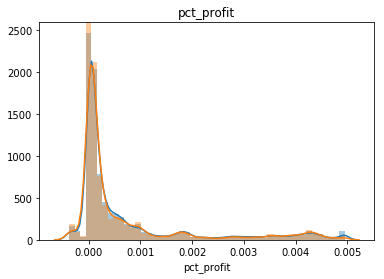

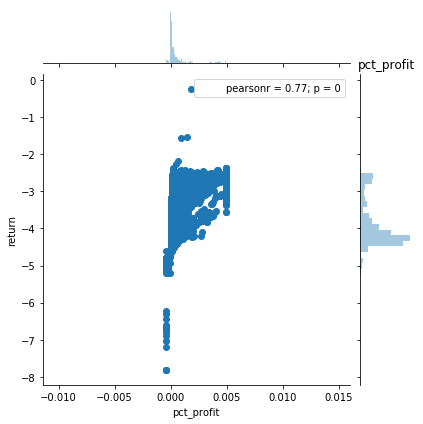

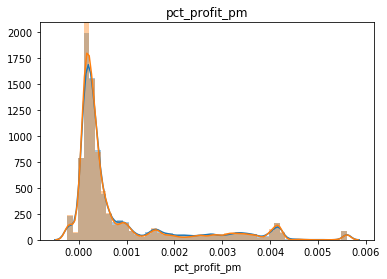

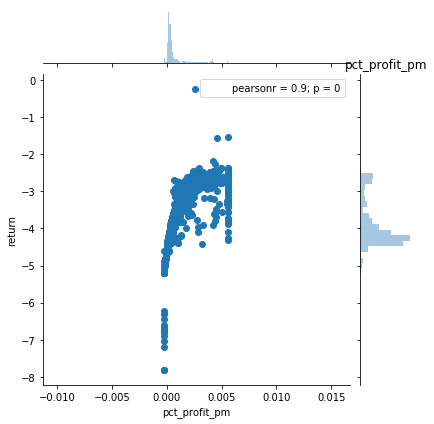

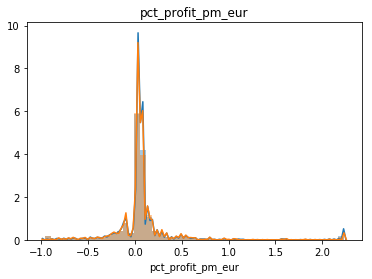

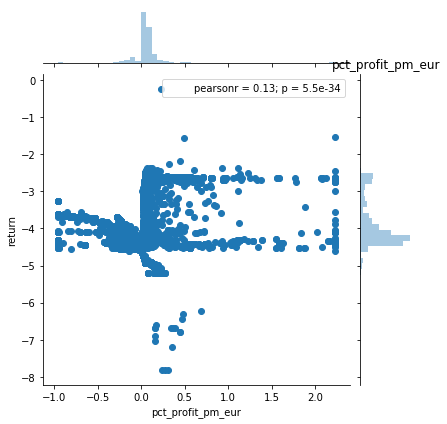

In [30]:
for col in ["pct_profit", "pct_profit_pm", 'pct_profit_pm_eur']:
    plot_continous(col)

In [31]:
feats = ['pf_duration', 'bought_year', 'sell_year', 'bought_qtr',
         'desk_id_enc', 'office_id_enc', 'pf_category_enc', 'country_code_enc', 
         'currency_enc', 'indicator_code_enc', 'type_enc', 'hedge_value_enc', 'status_enc',
        'euribor_rate', 'libor_rate', 'bought', 'sold', 'pct_profit', 'pct_profit_pm']

scores = cross_val_score(etr, X, y, scoring=r2score, cv=cvlist, verbose=10)
print(scores)
print(np.mean(scores), np.std(scores))

[CV]  ................................................................
[CV] ....................... , score=0.9605099804779359, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ........................ , score=0.334022514323949, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] ....................... , score=0.9583898592804613, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV] ....................... , score=0.9718264411685525, total=   0.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


[CV] ....................... , score=0.9460846105603072, total=   0.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s remaining:    0.0s


[CV] ....................... , score=0.9695924564831042, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.3s remaining:    0.0s


[CV] ....................... , score=0.9749100791762694, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.8s remaining:    0.0s


[CV] ....................... , score=0.9684570175292219, total=   0.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.5s remaining:    0.0s


[CV] ....................... , score=0.3400754214885724, total=   0.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.1s remaining:    0.0s


[CV] ....................... , score=0.8462521723716502, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9610772951708366, total=   0.5s
[CV]  ................................................................
[CV] ........................ , score=0.938199981857245, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.9605091936179146, total=   0.6s
[CV]  ................................................................
[CV] ....................... , score=0.9781979811720427, total=   0.5s
[CV]  ................................................................
[CV] ........................ , score=0.947146772082898, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.8348777110530908, total=   0.6s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.6s finished


/home/test/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


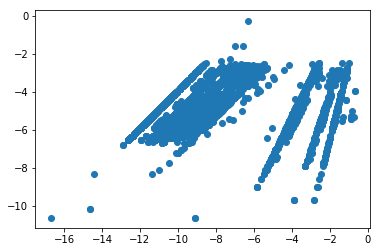

In [74]:
#Lets plot for a given currency profit per day v/s returns
tmp = train.copy()
plt.scatter(np.log(tmp['pct_profit'].clip(0,1) ** (1/(tmp['pf_duration_months']))), np.log(tmp['return'].clip(0, 1)))
plt.show()
#df.currency.value_counts()

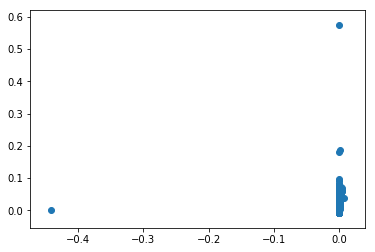

In [67]:
tmp = train.copy()
plt.scatter(np.log1p((tmp['sold']/tmp['bought']) ** (1/(tmp['pf_duration'])) - 1), np.log1p(tmp['return']))
plt.show()
#df.currency.valu

In [71]:
np.log(tmp['pct_profit'].clip(0,1) ** (1/(tmp['pf_duration'])))

/home/test/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


0       -0.276422
1       -0.164182
2       -0.255664
3       -0.185093
4       -0.185093
5       -0.185164
6       -0.185129
7       -0.185129
8       -0.057322
9       -0.058818
10      -0.180643
11      -0.186991
12      -0.186991
13      -0.205243
14      -0.056366
15      -0.153049
16      -0.185129
17      -0.185093
18      -0.168169
19      -0.186991
20      -0.187062
21      -0.178926
22      -0.198678
23      -0.185093
24      -0.054379
25      -0.162679
26      -0.186991
27      -0.186991
28      -0.186991
29      -0.198716
          ...    
9336    -0.335797
9337    -0.097865
9338    -0.316064
9339    -0.070326
9340    -1.324644
9341    -0.250000
9342    -1.334826
9343    -1.334826
9344    -0.239819
9345    -1.324644
9346         -inf
9347    -0.115113
9348    -1.334826
9349    -1.334826
9350         -inf
9351    -1.334826
9352    -1.334826
9353    -1.334826
9354         -inf
9355         -inf
9356    -1.334826
9357    -1.334826
9358    -1.334826
9359   -11.358763
9360    -3

In [76]:
test_preds = []
for tr, val in cvlist:
    etr.fit(X.iloc[tr], y.iloc[tr])
    val_score = metrics.r2_score(y.iloc[val], etr.predict(X.iloc[val]))
    print(val_score)
    tpreds = etr.predict(X_test)
    test_preds.append(tpreds)

0.962501803815
0.33449273222
0.959523885012
0.972439268516
0.946718449119
0.968757387459
0.974995759555
0.969646862857
0.34035102925
0.84602642715
0.960738941665
0.938435914416
0.960189701286
0.977113207756
0.946642052295
0.834052522352
0.948514062958
0.963032537238
0.848540581904
0.962720257065
0.965083093662
0.963271761338
0.350736310664
0.964272085168
0.965663834711
0.947600874353
0.972013874756
0.966228007075
0.967381388899
0.970641508809
0.340610866695
0.974515324378
0.966185941947
0.962443417792
0.960523796586
0.964604606236
0.86229830951
0.968920667405
0.960174176504
0.947392758924
0.957877293046
0.956444507167
0.967448135378
0.969743671578
0.964793547507
0.948096409271
0.954594562111
0.966026689225
0.368033059111
0.943398154798


In [84]:
sub['return'] = np.mean(test_preds, axis=0)
sub.head()

,portfolio_id,return
0,PF00001001,0.025611
1,PF00001004,0.028229
2,PF00001009,0.025564
3,PF00001013,0.025515
4,PF00001014,0.025515


In [85]:
sub.to_csv("data/etr_sub_v1.csv", index=False)